# Projet de reconnaissance faciale

# Reconnaissance faciale avec TensorFlow

In [1]:
# Standard libraries
import os
import sys
import time
import json
import csv
import logging
import hashlib
from datetime import datetime

# GUI libraries
import tkinter as tk
from tkinter import Tk, Label, filedialog, simpledialog, messagebox, ttk
from textwrap import wrap

# Data manipulation
import numpy as np
import pickle

# Image processing
import cv2
from PIL import Image, ImageTk
from scipy.special import expit

# TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.applications import MobileNetV2, DenseNet201
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras.callbacks import EarlyStopping

# Plotting
import matplotlib.pyplot as plt

# Miscellaneous
import glob

# Masquer tous les warnings
import warnings
warnings.filterwarnings('ignore')
# Masquer les warnings spécifiques à TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # vous l'avez déjà
tf.get_logger().setLevel('ERROR')
# Masquer les warnings de logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)


## Preparation des données

In [2]:
def prepare_datasets(dataset_path="dataset", img_height=224, img_width=224, train_split=0.6):
    """
    Prépare les datasets d'entraînement et de validation à partir d'un répertoire structuré.

    Arguments :
        dataset_path (str) : chemin vers le dossier contenant les sous-dossiers des classes.
        img_height (int) : hauteur des images après redimensionnement.
        img_width (int) : largeur des images après redimensionnement.
        batch_size (int) : taille des lots (non utilisé ici, mais utile pour le traitement futur).
        train_split (float) : fraction des images utilisées pour l'entraînement.

    Retourne :
        train_images (numpy.ndarray) : tableau des images d'entraînement.
        train_labels (numpy.ndarray) : labels d'entraînement (indices des classes).
        val_images (numpy.ndarray) : tableau des images de validation.
        val_labels (numpy.ndarray) : labels de validation (indices des classes).
        class_names (list) : noms des classes.
    """
    # Récupération des sous-dossiers représentant les classes
    class_names = tf.io.gfile.listdir(str(dataset_path))

    # Initialisation des listes pour les images et labels
    train_images = []
    train_labels = []
    val_images = []
    val_labels = []

    for label, class_name in enumerate(class_names):
        # Récupération des chemins des images pour chaque classe
        image_paths = glob.glob(f"{dataset_path}/{class_name}/*.jpg")

        for i, image_path in enumerate(image_paths):
            # Chargement et prétraitement des images
            img = tf.keras.preprocessing.image.load_img(
                image_path, target_size=(img_height, img_width)
            )
            img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0

            # Division en données d'entraînement et de validation
            if i < len(image_paths) * train_split:
                train_images.append(img_array)
                train_labels.append(label)
            else:
                val_images.append(img_array)
                val_labels.append(label)

    # Conversion en tableaux numpy
    train_images = np.array(train_images)
    train_labels = np.array(train_labels)
    val_images = np.array(val_images)
    val_labels = np.array(val_labels)

    num_classes = len(class_names)
    train_labels_onehot = np.eye(num_classes)[train_labels]
    val_labels_onehot = np.eye(num_classes)[val_labels]

    # Affichage des classes
    print("Classes:", class_names)

    return train_images, train_labels, val_images, val_labels, class_names, num_classes, train_labels_onehot, val_labels_onehot

train_images, train_labels, val_images, val_labels, class_names, num_classes, train_labels_onehot, val_labels_onehot = prepare_datasets()

Classes: ['Antoine  Lavenseau', 'Antoine Conguisti', 'Camille Raad', 'Cléa Flatres', 'Edwin Treny', 'Franck Tene', 'Jean-loup Dagniaux', 'Lea Laborde', 'Luther Mengata', 'Mathis Wauters', 'Pierre Latorse', 'Pierre Martin', 'Samuel Jarjanette', 'Theophile Mariotte', 'Valentin Hervouet', 'Victor Billat', 'Vincent Verlaan', 'Yan Langlois']


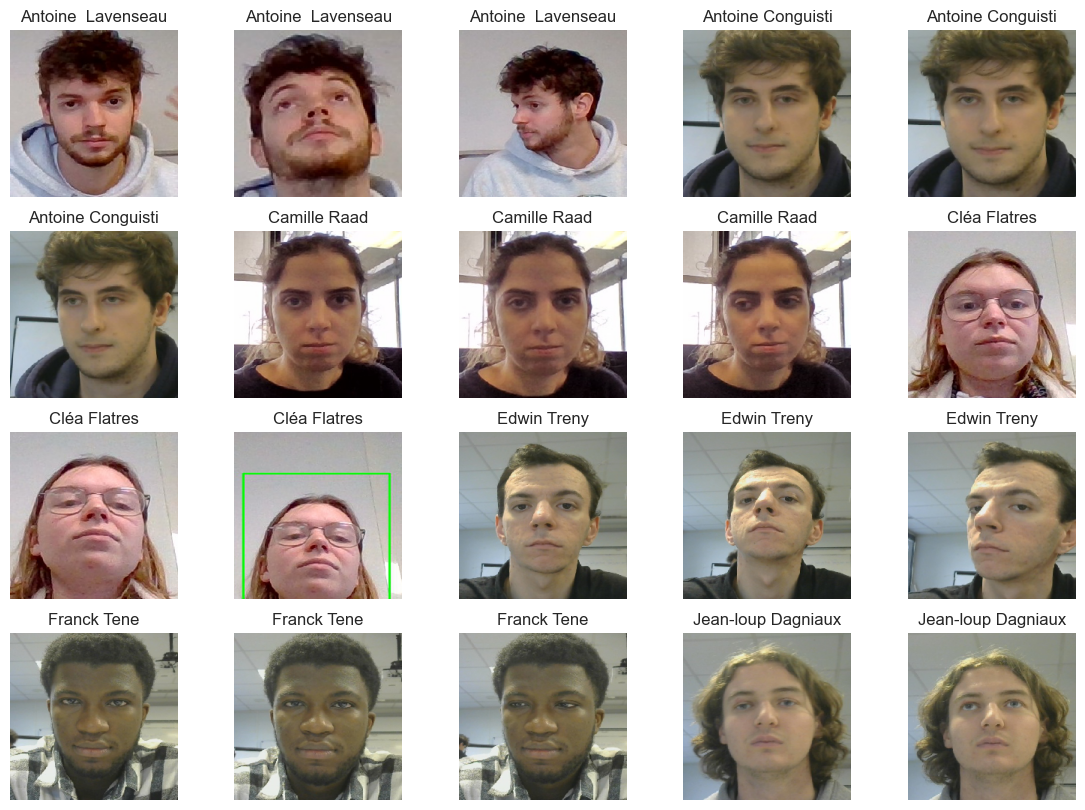

In [3]:
plt.figure(figsize=(14, 10))
for i in range(20):
    plt.subplot(4, 5, i + 1)
    plt.imshow(train_images[i])
    plt.title(class_names[train_labels[i]])  # Utilisation des indices des classes
    plt.axis("off")
plt.show()

## Définir le modèle

In [4]:
def build_model(num_classes=num_classes):
    """
    Construit un modèle basé sur MobileNetV2 avec des couches personnalisées.

    Arguments :
        num_classes (int) : nombre de classes pour la classification.

    Retourne :
        model (tf.keras.Model) : le modèle compilé.
    """
    # Charger MobileNetV2 sans la dernière couche
    base_model = MobileNetV2(input_shape=(224, 224, 3),
                             include_top=False,
                             weights='imagenet')

    # Geler ou non les couches du modèle pré-entraîné
    base_model.trainable = False

    # Ajouter des couches personnalisées
    model = models.Sequential()
    model.add(base_model)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(num_classes))

    # Compiler le modèle
    model.compile(optimizer='Adam',
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  metrics=['accuracy'])

    # Résumé du modèle
    model.summary()

    return model

model = build_model()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 18)             │        23,058 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,281,042 (8.70 MB)

 Trainable params: 23,058 (90.07 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

## Data augmentation et entraînement du modèle

C:\Users\waute\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Époque 4: Nouveau meilleur modèle sauvegardé!
Accuracy d'entraînement: 9.26%
Accuracy de validation: 2.78%

Époque 5: Nouveau meilleur modèle sauvegardé!
Accuracy d'entraînement: 7.41%
Accuracy de validation: 8.33%

Époque 6: Nouveau meilleur modèle sauvegardé!
Accuracy d'entraînement: 11.11%
Accuracy de validation: 11.11%

Époque 7: Nouveau meilleur modèle sauvegardé!
Accuracy d'entraînement: 14.81%
Accuracy de validation: 13.89%

Époque 10: Nouveau meilleur modèle sauvegardé!
Accuracy d'entraînement: 18.52%
Accuracy de validation: 25.00%

Époque 11: Nouveau meilleur modèle sauvegardé!
Accuracy d'entraînement: 29.63%
Accuracy de validation: 27.78%

Époque 13: Nouveau meilleur modèle sauvegardé!
Accuracy d'entraînement: 31.48%
Accuracy de validation: 30.56%

Époque 14: Nouveau meilleur modèle sauvegardé!
Accuracy d'entraînement: 42.59%
Accuracy de validation: 36.11%

Époque 18: Nouveau meilleur modèle sauvegardé!
Accuracy d'entraînement: 64.81%
Accuracy de validation: 47.22%

Époque 2

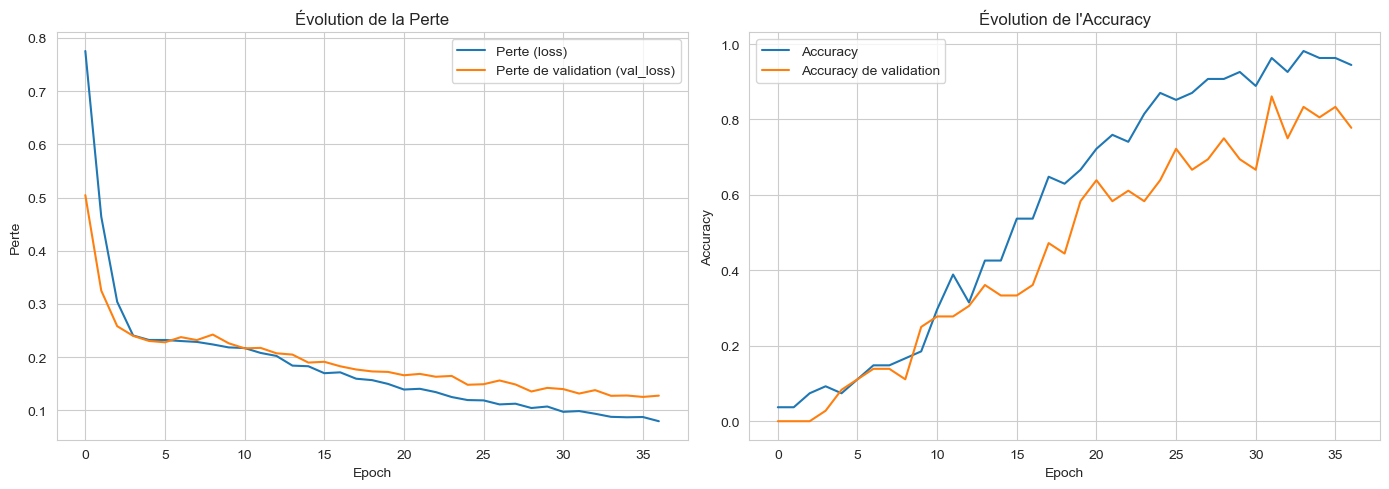


Meilleures performances à l'époque 32:
Accuracy d'entraînement: 96.30%
Accuracy de validation: 86.11%


In [5]:
def train_model_with_augmentation(model=model, train_images=train_images, train_labels_onehot=train_labels_onehot, val_images=val_images, val_labels_onehot=val_labels_onehot):
    """
    Entraîne un modèle en utilisant l'augmentation de données et sauvegarde le meilleur modèle.

    Arguments :
        model (tf.keras.Model) : modèle à entraîner.
        train_images (numpy.ndarray) : images d'entraînement.
        train_labels_onehot (numpy.ndarray) : labels d'entraînement.
        val_images (numpy.ndarray) : images de validation.
        val_labels_onehot (numpy.ndarray) : labels de validation.
        batch_size (int) : taille du batch pour les générateurs de données.
        epochs (int) : nombre d'époques pour l'entraînement.

    Retourne :
        history (tf.keras.callbacks.History) : objet contenant l'historique de l'entraînement.
    """

    # Data augmentation
    train_datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True
    )

    # Callback personnalisé pour sauvegarder le meilleur modèle
    class BestModelCheckpoint(tf.keras.callbacks.Callback):
        def __init__(self):
            super().__init__()
            self.best_val_accuracy = 0
            self.best_epoch = 0

        def on_epoch_end(self, epoch, logs=None):
            current_val_accuracy = logs.get('val_accuracy')
            if current_val_accuracy > self.best_val_accuracy:
                self.best_val_accuracy = current_val_accuracy
                self.best_epoch = epoch
                self.model.save("face_recognition_model.keras")
                print(f"\nÉpoque {epoch + 1}: Nouveau meilleur modèle sauvegardé!")
                print(f"Accuracy d'entraînement: {logs.get('accuracy')*100:.2f}%")
                print(f"Accuracy de validation: {current_val_accuracy*100:.2f}%")

    early_stopping = EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        verbose=1,
    )

    best_model_checkpoint = BestModelCheckpoint()

    # Préparer les générateurs de données
    train_generator = train_datagen.flow(train_images, train_labels_onehot, batch_size=32)
    val_generator = train_datagen.flow(val_images, val_labels_onehot, batch_size=32)

    # Entraîner le modèle
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=50,
        callbacks=[early_stopping, best_model_checkpoint],
        verbose=0
    )

    # Afficher la perte et l'accuracy
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Perte (loss)')
    plt.plot(history.history['val_loss'], label='Perte de validation (val_loss)')
    plt.title('Évolution de la Perte')
    plt.xlabel('Epoch')
    plt.ylabel('Perte')
    plt.legend()

    # Afficher l'accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Accuracy')
    plt.plot(history.history['val_accuracy'], label='Accuracy de validation')
    plt.title('Évolution de l\'Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Afficher les meilleures performances
    best_epoch = best_model_checkpoint.best_epoch
    print(f"\nMeilleures performances à l'époque {best_epoch + 1}:")
    print(f"Accuracy d'entraînement: {history.history['accuracy'][best_epoch]*100:.2f}%")
    print(f"Accuracy de validation: {history.history['val_accuracy'][best_epoch]*100:.2f}%")

    return model

# Entraîner le modèle avec augmentation de données
model = train_model_with_augmentation()

In [6]:
def prepare_train_and_evaluate(dataset_path="dataset", img_height=224, img_width=224, train_split=0.6):
    """
    Prépare les datasets, construit le modèle, puis entraîne le modèle avec augmentation de données.

    Arguments :
        dataset_path (str) : chemin vers le dossier contenant les sous-dossiers des classes.
        img_height (int) : hauteur des images après redimensionnement.
        img_width (int) : largeur des images après redimensionnement.
        train_split (float) : fraction des images utilisées pour l'entraînement.
        num_classes (int) : nombre de classes pour la classification.

    Retourne :
        history (tf.keras.callbacks.History) : objet contenant l'historique de l'entraînement.
        model (tf.keras.Model) : le modèle entraîné.
    """
    # Préparation des datasets
    train_images, train_labels, val_images, val_labels, class_names, num_classes, train_labels_onehot, val_labels_onehot = prepare_datasets(
        dataset_path, img_height, img_width, train_split)

    # Construction du modèle
    model = build_model(num_classes)

    # Entraînement du modèle avec augmentation de données
    train_model_with_augmentation(model, train_images, train_labels_onehot, val_images, val_labels_onehot)
    model = tf.keras.models.load_model("face_recognition_model.keras")

    return model

#model = prepare_train_and_evaluate()

## Reconnaissance faciale en temps réel

In [7]:
from ultralytics import YOLO
# Charger le modèle sauvegardé
model = tf.keras.models.load_model("face_recognition_model.keras")
class_names = tf.io.gfile.listdir(str('dataset'))

# Initialiser le classificateur de visage d'OpenCV
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Dimensions des images attendues
img_height = 224
img_width = 224

OBJETS_SURVEILLES = {
    'Sunglasses': 505,
    'Hat': 243,
    'Shorts': 456,
    'Skirt': 463,
    'Miniskirt': 334,
    'Helmet': 248,
    'Kitchen Knife': 292,
    'Shotgun': 457,
    'Handgun': 238
}

def charger_modele_yolo():
    """Charge le modèle YOLO"""
    # Désactiver les logs de YOLO
    logging.getLogger("ultralytics").setLevel(logging.WARNING)
    return YOLO("yolov8n-oiv7.pt", verbose=False)

def detecter_objets(frame, model_yolo):
    """Détecte les objets interdits dans la frame"""
    # Désactiver la sortie stdout temporairement
    old_stdout = sys.stdout
    sys.stdout = open(os.devnull, 'w')

    results = model_yolo(frame, verbose=False)

    # Restaurer la sortie stdout
    sys.stdout = old_stdout

    detections = []

    for r in results:
        boxes = r.boxes
        for box in boxes:
            cls_id = int(box.cls[0])
            for nom_objet, id_classe in OBJETS_SURVEILLES.items():
                if cls_id == id_classe:
                    x1, y1, x2, y2 = box.xyxy[0]
                    confidence = float(box.conf[0])
                    if confidence > 0.4:
                        detections.append({
                            'objet': nom_objet,
                            'confiance': confidence,
                            'coords': (int(x1), int(y1), int(x2), int(y2))
                        })
    return detections

# Fonction pour effectuer une prédiction
def capture_face(prenom, nom):
    # Créer le dossier pour enregistrer les images si il n'existe pas
    folder_name = f"dataset/{prenom.capitalize()} {nom.capitalize()}"
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)

    # Ouvrir la caméra
    cap = cv2.VideoCapture(0)
    captured_images = 0
    directions = ["Regardez en face", "Regardez en haut", "Regardez vers la droite", "Regardez en bas", "Regardez vers la gauche"]
    images_per_direction = 1  # Nombre d'images par direction
    total_images = len(directions) * images_per_direction

    direction_index = 0

    while captured_images < total_images:
        # Récupérer l'étape actuelle sans print
        current_direction = directions[direction_index]

        # Pause de 3 secondes avec affichage de l'étape actuelle
        for i in range(3, 0, -1):
            ret, frame = cap.read()
            if not ret:
                break
            # Ajouter le texte pour guider l'utilisateur
            cv2.putText(frame, f"{current_direction} dans {i} secondes",
                        (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 2)
            cv2.imshow('Capturer le visage', frame)
            cv2.waitKey(1000)

        while captured_images < (direction_index + 1) * images_per_direction:
            ret, frame = cap.read()
            if not ret:
                break

            # Convertir en niveaux de gris pour la détection
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

            # Détection des visages
            faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

            for (x, y, w, h) in faces:
                # Élargir la zone pour prendre toute la tête
                x_head = max(0, x - int(0.2 * w))  # 20% de plus sur les côtés
                y_head = max(0, y - int(0.3 * h))  # 30% de plus en haut pour inclure plus de tête
                w_head = min(frame.shape[1] - x_head, int(w * 1.4))  # Largeur augmentée
                h_head = min(frame.shape[0] - y_head, int(h * 1.6))  # Hauteur augmentée

                # Extraire toute la tête
                head = frame[y_head:y_head+h_head, x_head:x_head+w_head]

                # Enregistrer l'image
                head_filename = f"{folder_name}/head_{captured_images}.jpg"
                cv2.imwrite(head_filename, head)
                captured_images += 1

                # Ajouter un rectangle et des informations à l'écran
                cv2.putText(frame, f"Image {captured_images}/{total_images}",
                            (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
                cv2.rectangle(frame, (x_head, y_head), (x_head+w_head, y_head+h_head), (0, 255, 0), 2)

            # Afficher l'étape actuelle pendant la capture
            cv2.putText(frame, f"Etape actuelle : {current_direction}",
                        (10, frame.shape[0] - 20), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 0), 2)

            # Afficher le flux vidéo avec les visages détectés
            cv2.imshow('Capturer le visage', frame)

            # Quitter avec la touche 'q'
            if cv2.waitKey(1) & 0xFF == ord('q'):
                cap.release()
                cv2.destroyAllWindows()
                return

        # Passer à la prochaine direction
        direction_index = (direction_index + 1) % len(directions)

    # Libérer les ressources
    cap.release()
    cv2.destroyAllWindows()
    show_message(f"Enregistrement du visage terminé. Veuillez entrainer le modèle.")


# Fonction pour effectuer une prédiction
def predict_face(face, model, class_names, threshold=0.6):
    """
    Prédit la classe d'un visage et vérifie s'il est inconnu.
    Args:
        face: Image du visage.
        model: Modèle de reconnaissance faciale.
        class_names: Liste des noms de classes.
        threshold: Seuil de confiance pour les visages inconnus.

    Returns:
        predicted_class: Nom de la classe prédite ou 'Inconnu'.
        confidence: Confiance de la prédiction.
    """
    face = cv2.resize(face, (img_width, img_height))  # Redimensionner
    face_array = img_to_array(face) / 255.0  # Normaliser
    face_array = np.expand_dims(face_array, axis=0)  # Ajouter une dimension batch

    # Obtenir les prédictions (logits)
    probabilities = model.predict(face_array, verbose=0)[0]  # Sortie du modèle
    softmax_p = np.exp(probabilities) / np.sum(np.exp(probabilities), axis=-1)  # Probabilités softmax

    # Obtenir la classe avec la probabilité maximale
    max_index = np.argmax(softmax_p)
    confidence = expit(probabilities[max_index])

    # Vérifier si le visage est inconnu
    if confidence < threshold:
        return "Inconnu", confidence
    else:
        predicted_class = class_names[max_index]
        return predicted_class, confidence

def show_message(message, duration=5):
    """
    Affiche un message dans une fenêtre pendant une durée spécifiée.
    """
    root = Tk()
    root.title("Prochaine étape")
    root.geometry("300x100")
    label = Label(root, text=message, font=("Helvetica", 16), wraplength=280)
    label.pack(expand=True)
    root.after(duration * 1000, root.destroy)  # Ferme la fenêtre après `duration` secondes
    root.mainloop()

In [8]:
import textwrap
def analyze_face(camera_mode, image_path=None):
    """
    Analyse les visages, objets et génère une description de l'image
    Args:
        camera_mode: Mode de la caméra ("Entree" ou "Sortie")
        image_path: Chemin de l'image à analyser. Si None, utilise la caméra
    """
    log_file = "face_detection_logs.csv"
    model_yolo = charger_modele_yolo()

    # Initialisation du modèle de captioning
    caption_model = tf.keras.models.load_model('caption_model.keras')
    with open('tokenizer.pkl', 'rb') as f:
        data = pickle.load(f)
        tokenizer = data['tokenizer']
        max_length = data['max_length']

    # Configuration du modèle DenseNet
    model_densenet = DenseNet201()
    feature_extractor = tf.keras.Model(inputs=model_densenet.input,
                                     outputs=model_densenet.layers[-2].output)

    if not os.path.exists(log_file):
        with open(log_file, 'w', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(['Date', 'Heure', 'Personne', 'Objets_Interdits', 'Mode', 'Description'])

    last_person_state = {}

    def generate_image_caption(image):
        # Redimensionner l'image pour DenseNet
        img_array = cv2.resize(image, (224, 224))
        img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
        img_array = img_array / 255.
        img_array = np.expand_dims(img_array, axis=0)

        # Extraire les caractéristiques
        feature = feature_extractor.predict(img_array, verbose=0)

        # Générer la description
        in_text = "startseq"
        for i in range(max_length):
            sequence = tokenizer.texts_to_sequences([in_text])[0]
            sequence = pad_sequences([sequence], maxlen=max_length)

            try:
                y_pred = caption_model.predict([feature, sequence], verbose=0)
                y_pred = np.argmax(y_pred)

                word = next((word for word, index in tokenizer.word_index.items()
                           if index == y_pred), None)

                if word is None:
                    break

                in_text += " " + word

                if word == 'endseq':
                    break
            except Exception as e:
                print(f"Erreur lors de la génération de la description: {str(e)}")
                return "Impossible de générer une description"

        return in_text.replace('startseq', '').replace('endseq', '').strip()

    if image_path:
        frame = cv2.imread(image_path)
        if frame is None:
            messagebox.showerror("Erreur", "Impossible de charger l'image")
            return

        # Générer la description de l'image
        description = generate_image_caption(frame)

        while True:
            display_frame = frame.copy()
            detections_objets = detecter_objets(frame, model_yolo)
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

            objets_detectes = [f"{det['objet']} ({det['confiance']:.2f})" for det in detections_objets]

            for (x, y, w, h) in faces:
                x_head = max(0, x - int(0.2 * w))
                y_head = max(0, y - int(0.3 * h))
                w_head = min(frame.shape[1] - x_head, int(w * 1.4))
                h_head = min(frame.shape[0] - y_head, int(h * 1.6))

                head = frame[y_head:y_head+h_head, x_head:x_head+w_head]
                predicted_class, confidence = predict_face(head, model, class_names)

                if predicted_class not in last_person_state or last_person_state[predicted_class] != camera_mode:
                    now = datetime.now()
                    date_str = now.strftime("%Y-%m-%d")
                    time_str = now.strftime("%H:%M:%S")
                    with open(log_file, 'a', newline='') as f:
                        writer = csv.writer(f)
                        writer.writerow([date_str, time_str, predicted_class,
                                       ', '.join(objets_detectes), camera_mode, description])

                    last_person_state[predicted_class] = camera_mode

                color = (0, 255, 0) if predicted_class != "Inconnu" else (0, 0, 255)
                text = f"{predicted_class} {confidence*100:.2f}%" if predicted_class != "Inconnu" else "Visage Inconnu"

                cv2.rectangle(display_frame, (x_head, y_head), (x_head+w_head, y_head+h_head), color, 2)
                cv2.putText(display_frame, text, (x_head, y_head - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2)

            # Afficher la description sur l'image
            desc_lines = textwrap.wrap(description, width=40)
            y_pos = 30
            for line in desc_lines:
                # Obtenir la taille du texte pour créer le rectangle de fond
                (text_width, text_height), _ = cv2.getTextSize(line, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 1)

                # Dessiner un rectangle blanc comme fond
                cv2.rectangle(display_frame,
                             (5, y_pos - text_height - 5),  # Point supérieur gauche
                             (15 + text_width, y_pos + 5),   # Point inférieur droit
                             (255, 255, 255),                # Couleur du fond (blanc)
                             -1)                             # -1 pour remplir le rectangle

                # Dessiner le texte noir avec épaisseur normale
                cv2.putText(display_frame, line, (10, y_pos),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0), 1)  # épaisseur changée à 1

                y_pos += 25

            for det in detections_objets:
                x1, y1, x2, y2 = det['coords']
                nom = f"{det['objet']} {det['confiance']:.2f}"
                cv2.rectangle(display_frame, (x1, y1), (x2, y2), (0, 0, 255), 2)
                cv2.putText(display_frame, nom, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

            cv2.imshow('Analyse d\'image', display_frame)

            if cv2.waitKey(1) & 0xFF == ord('q'):
                break

    else:
        cap = cv2.VideoCapture(0)
        while True:
            ret, frame = cap.read()
            if not ret:
                break

            detections_objets = detecter_objets(frame, model_yolo)
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

            current_time = time.time()
            objets_detectes = [f"{det['objet']} ({det['confiance']:.2f})" for det in detections_objets]

            for (x, y, w, h) in faces:
                x_head = max(0, x - int(0.2 * w))
                y_head = max(0, y - int(0.3 * h))
                w_head = min(frame.shape[1] - x_head, int(w * 1.4))
                h_head = min(frame.shape[0] - y_head, int(h * 1.6))

                head = frame[y_head:y_head+h_head, x_head:x_head+w_head]
                predicted_class, confidence = predict_face(head, model, class_names)

                if (predicted_class not in last_person_state or last_person_state[predicted_class] != camera_mode) or \
                   (current_time - last_log_time >= 60):
                    now = datetime.now()
                    with open(log_file, 'a', newline='') as f:
                        writer = csv.writer(f)
                        writer.writerow([
                            now.strftime("%Y-%m-%d"),
                            now.strftime("%H:%M:%S"),
                            predicted_class,
                            ', '.join(objets_detectes),
                            camera_mode,
                        ])

                    last_person_state[predicted_class] = camera_mode
                    last_log_time = current_time

                color = (0, 255, 0) if predicted_class != "Inconnu" else (0, 0, 255)
                text = f"{predicted_class} {confidence*100:.2f}%" if predicted_class != "Inconnu" else "Visage Inconnu"

                cv2.rectangle(frame, (x_head, y_head), (x_head+w_head, y_head+h_head), color, 2)
                cv2.putText(frame, text, (x_head, y_head - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2)

            for det in detections_objets:
                x1, y1, x2, y2 = det['coords']
                nom = f"{det['objet']} {det['confiance']:.2f}"
                cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 0, 255), 2)
                cv2.putText(frame, nom, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

            cv2.imshow('Reconnaissance Faciale et Detection d\'objets', frame)

            if cv2.waitKey(1) & 0xFF == ord('q'):
                break

        cap.release()

    cv2.destroyAllWindows()

In [9]:
def check_password_and_mode(root, password_manager):
    dialog = tk.Toplevel(root)
    dialog.title("Authentification")
    dialog.grab_set()

    password_var = tk.StringVar()
    mode_var = tk.StringVar(value="Entree")
    result = {'authenticated': False, 'mode': None}

    frame = tk.Frame(dialog, padx=20, pady=20)
    frame.pack(expand=True, fill='both')

    tk.Label(frame, text="Mot de passe:").pack(pady=5)
    password_entry = tk.Entry(frame, show="*", textvariable=password_var)
    password_entry.pack(pady=5)

    tk.Label(frame, text="Mode caméra:").pack(pady=5)
    tk.Radiobutton(frame, text="Entrée", variable=mode_var, value="Entree").pack()
    tk.Radiobutton(frame, text="Sortie", variable=mode_var, value="Sortie").pack()

    def validate():
        if password_manager.verify_password(password_var.get()):
            result['authenticated'] = True
            result['mode'] = mode_var.get()
            dialog.destroy()
        else:
            messagebox.showerror("Erreur", "Mot de passe incorrect")

    def on_close():
        result['authenticated'] = False
        dialog.destroy()

    button_frame = tk.Frame(frame)
    button_frame.pack(pady=10)

    tk.Button(button_frame, text="Valider", command=validate).pack(side=tk.LEFT, padx=5)
    tk.Button(button_frame, text="Annuler", command=on_close).pack(side=tk.LEFT, padx=5)

    dialog.protocol("WM_DELETE_WINDOW", on_close)

    # Centrer la fenêtre
    dialog.update_idletasks()
    width = dialog.winfo_width()
    height = dialog.winfo_height()
    x = (dialog.winfo_screenwidth() // 2) - (width // 2)
    y = (dialog.winfo_screenheight() // 2) - (height // 2)
    dialog.geometry('{}x{}+{}+{}'.format(width, height, x, y))

    dialog.wait_window()
    return result

def create_authenticated_interface(root, password_manager, camera_mode):
    root.deiconify()
    # Nettoyer la fenêtre principale
    for widget in root.winfo_children():
        widget.destroy()

    root.title("Reconnaissance Faciale et Description d'Images")

    # Frame principale avec scrollbar
    main_frame = ttk.Frame(root)
    main_frame.pack(expand=True, fill='both', padx=10, pady=10)

    # Variable pour stocker la dernière description générée
    description_var = tk.StringVar()

    def logout():
        root.withdraw()
        show_login_screen(root)

    def start_capture():
        prenom = simpledialog.askstring("Prénom", "Entrez votre prénom:")
        nom = simpledialog.askstring("Nom", "Entrez votre nom:")
        if prenom and nom:
            capture_face(prenom, nom)

    def change_password_dialog():
        old_pwd = simpledialog.askstring("Changement de mot de passe", "Ancien mot de passe:", show='*')
        new_pwd = simpledialog.askstring("Changement de mot de passe", "Nouveau mot de passe:", show='*')
        if old_pwd and new_pwd:
            if password_manager.change_password(old_pwd, new_pwd):
                messagebox.showinfo("Succès", "Mot de passe modifié avec succès")
            else:
                messagebox.showerror("Erreur", "Impossible de modifier le mot de passe")

    def start_analyze_face():
        analyze_face(camera_mode)

    def start_analyze_image():
        file_path = filedialog.askopenfilename(
            title="Sélectionner une image",
            filetypes=(("Images", "*.jpg *.jpeg *.png"), ("Tous les fichiers", "*.*"))
        )
        if file_path:
            # Mettre à jour le label pour indiquer que l'analyse est en cours
            status_label.config(text="Analyse en cours...")
            root.update()

            # Lancer l'analyse
            analyze_face(camera_mode, image_path=file_path)

            # Lire la dernière ligne du fichier log pour obtenir la description
            try:
                with open('face_detection_logs.csv', 'r', newline='') as f:
                    last_line = list(csv.reader(f))[-1]
                    description = last_line[-1]  # La description est dans la dernière colonne
                    description_var.set(description)
                    status_label.config(text="Analyse terminée")
            except Exception as e:
                description_var.set("Impossible de récupérer la description")
                status_label.config(text="Erreur lors de l'analyse")

    # Création des widgets
    title_label = ttk.Label(main_frame, text="Système de Reconnaissance et Description", font=('Helvetica', 14, 'bold'))
    title_label.pack(pady=10)

    status_label = ttk.Label(main_frame, text="")
    status_label.pack()

    # Boutons pour chaque fonctionnalité
    capture_button = ttk.Button(main_frame, text="Enregistrer un visage", command=start_capture)
    capture_button.pack(pady=5)

    train_button = ttk.Button(main_frame, text="Entrainer le modèle", command=prepare_train_and_evaluate)
    train_button.pack(pady=5)

    image_button = ttk.Button(main_frame, text="Analyser une image", command=start_analyze_image)
    image_button.pack(pady=5)

    camera_button = ttk.Button(main_frame, text="Reconnaissance faciale", command=start_analyze_face)
    camera_button.pack(pady=5)

    # Frame pour la description
    description_frame = ttk.LabelFrame(main_frame, text="Description de l'image")
    description_frame.pack(pady=10, padx=5, fill='x')

    description_label = ttk.Label(description_frame,
                                textvariable=description_var,
                                wraplength=400,
                                justify='left')
    description_label.pack(pady=5, padx=5)

    # Boutons administratifs en bas
    admin_frame = ttk.Frame(main_frame)
    admin_frame.pack(side='bottom', pady=10)

    change_pwd_button = ttk.Button(admin_frame, text="Changer le mot de passe", command=change_password_dialog)
    change_pwd_button.pack(side='left', padx=5)

    logout_button = ttk.Button(admin_frame, text="Se déconnecter", command=logout)
    logout_button.pack(side='left', padx=5)

    mode_label = ttk.Label(admin_frame, text=f"Mode caméra: {camera_mode}")
    mode_label.pack(side='left', padx=5)

def create_password_manager():
    class PasswordManager:
        def __init__(self, config_file='password_config.json'):
            self.config_file = config_file
            self.current_password = None
            self.load_password()

        def hash_password(self, password):
            return hashlib.sha256(password.encode()).hexdigest()

        def load_password(self):
            if os.path.exists(self.config_file):
                with open(self.config_file, 'r') as f:
                    config = json.load(f)
                    self.current_password = config.get('password')

            # Si aucun mot de passe n'existe, définir un mot de passe par défaut
            if not self.current_password:
                default_password = self.hash_password('admin')
                self.save_password(default_password)

        def save_password(self, hashed_password):
            with open(self.config_file, 'w') as f:
                json.dump({'password': hashed_password}, f)
            self.current_password = hashed_password

        def verify_password(self, input_password):
            hashed_input = self.hash_password(input_password)
            return hashed_input == self.current_password

        def change_password(self, old_password, new_password):
            if self.verify_password(old_password):
                new_hashed_password = self.hash_password(new_password)
                self.save_password(new_hashed_password)
                return True
            return False

    return PasswordManager()

def check_password(password_manager):
    input_password = simpledialog.askstring("Authentification", "Entrez le mot de passe:", show='*')
    return password_manager.verify_password(input_password)

# Lancer l'application
def show_login_screen(root):
    password_manager = create_password_manager()

    while True:
        result = check_password_and_mode(root, password_manager)
        if result['authenticated']:
            create_authenticated_interface(root, password_manager, result['mode'])
            break
        else:
            retry = messagebox.askretrycancel("Erreur", "Authentification annulée")
            if not retry:
                root.quit()
                break

def start_application():
    root = tk.Tk()
    root.title("Login")

    # Définir une taille minimale pour la fenêtre principale
    root.minsize(450, 150)

    # Centrer la fenêtre principale
    width = 300
    height = 400
    x = (root.winfo_screenwidth() // 2) - (width // 2)
    y = (root.winfo_screenheight() // 2) - (height // 2)
    root.geometry(f'{width}x{height}+{x}+{y}')

    # Masquer la fenêtre principale au démarrage
    root.withdraw()

    show_login_screen(root)
    root.mainloop()

if __name__ == "__main__":
    start_application()